# Introduction
* Offline or *a posterior* testing

# Import libraries

In [1]:
# import all python, pytorch, and ML libraries, classes and functions
from NN_funcs import *

# for plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# Start main

## Set parameters

In [2]:
# Data type
casenum       = [1]       # dataset case number(s) (see DataAcqu_LSTM.ipynb or data_funcs.py)
casenum_test  = [1]          # case to be tested
# parameters used for data acquisition
target_T        = 1          # target time period for sampling frequency
seq_len_T       = 64         # target sequence length (sampling frequency) of LSTM input for target_T
dt_target       = target_T/seq_len_T

normEnergy    = True         # normalize energy
interpIO      = True         # interpolate data
set_dt_seq    = True         # set dt for `interpIO` such that time length of `seq_len` data points = 1 time period
dt_T          = 1.0          # dt for interpIO
if set_dt_seq:
    seq_len     = int(dt_T/dt_target)  # sequence length (lag time) for LSTM input
else:
    seq_len     = seq_len_T            # sequence length (lag time) for LSTM input

add_IP_time   = False           # add time info as an additional input
add_IP_ke_pe_T= False           # add ke and pe decay time scales as additional inputs (make sure the IPs are normalized)
add_IP_Fr_Gn  = False           # add Frh and Gn as additional inputs

Ntrainper     = 0.9            # number of training data (%)

# Hyperparameters (from training)
# data
n_val         = 0.1          # validation data (ratio)
n_inputs      = 4            # number of inputs
n_outputs     = 4            # number of outputs
# network architecture
model_name    = 'LSTM'       # model name: 'SingleMLP' 'ResNet' 'DenseNet' 'LSTM'
# dense layers
n_per_layer   = 15           # number of neurons on all hidden dense layers (manually update model if needed)
n_layers      = 1            # number of dense layers - ResNet, DenseNet
drp_in        = 0            # probability value for input dropout 
drp_hd        = 0            # probability value for hidden layer dropout
# RNN/LSTM layers
n_lstm_layers = 4            # number of layers - LSTM blocks/cells
hidden_size   = 10           # hidden state size of LSTM cell
# other settings
lkyReLU_alpha = 0.1          # slope of leakyReLU
lrate         = 1e-3         # learning rate
reg_type      = 'None'       # manual weight regularization 'L1' 'L2' 'None'
reg_factor    = 1e-6         # regularization factor
# training parameters
nepoch        = 10         # number of training epochs (additional for restart runs)
batch_size    = 10          # batch size
scaleData     = False        # scale data (e.g.: naive min-max scaling of I/O)
# restart NN model
restartTrain  = False        # restart training
ensmbleTrain  = False        # restart training with ensemble (first restart training for a few epoch and figure out ensm_errval)
ensmb_errval  = 1.7e-6       # models with error below this will be used for ensemble. Choose manually based on original training curve
nepoch_in     = 4000         # nepoch of original (old) model
lrate_restart = 5e-4         # new lrate

# Device settings
disable_cuda  = True        # disable GPU?

# Model evaluation regime (in NN training or testing data regimes)
eval_regime   = 'training'   # training testing

# Save figures & output data
saveFig       = False   # save figure(s) or not
saveData      = False  # save data of plots for full plotting

In [3]:
# get casenames
casename     = [get_casename(i) for i in casenum]

# model filename
modelfname = f'SSTRANS_EnergyEqn_normEnergy{int(normEnergy)}_interpIO{int(interpIO)}_setdt{int(set_dt_seq)}-T{dt_T}_'\
                f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}'
for i in range(len(casenum)):              # casename(s)
    modelfname = f'{modelfname}_{casename[i]}'
modelfname = f'{modelfname}_PyTModel_{model_name}_seqlen{seq_len}_nLSTMLayers{n_lstm_layers}_hiddensize{hidden_size}_'\
                f'nMLPLayers{n_layers}_nNeurons{n_per_layer}_batch{batch_size}_lr{lrate}_'\
                f'scaleData{scaleData}_nin{n_inputs}_Ntrain{Ntrainper}'
if ensmbleTrain or restartTrain:           # restart filename
    modelfname = f'{modelfname}_nepoch{nepoch_in}'
    lrate        = lrate_restart
    saveFnameRes =f'_restartEpoch{nepoch_in}_lr{lrate}'
else:
    modelfname = f'{modelfname}_nepoch{nepoch}'
savefilename = f'Data_models/{modelfname}'

# testing data filename
# get casenames
casename     = [get_casename(i) for i in casenum_test]
shuffledata  = False             # randomly shuffle training data or not
loaddatapath = f'Data_training/RANSdata_shuffle{shuffledata}_in-Energy_LSTM_seqlen{seq_len}_'\
            f'normEnergy{int(normEnergy)}_interpIO{int(interpIO)}_setdt{int(set_dt_seq)}-T{dt_T}_'\
            f'IPtime{int(add_IP_time)}_IPKEPEtime{int(add_IP_ke_pe_T)}_IPFrGn{int(add_IP_Fr_Gn)}'
for i in range(len(casenum_test)):    # casename(s)
    loaddatapath = f'{loaddatapath}_{casename[i]}'
loaddatapath = f'{loaddatapath}_Ntrain{Ntrainper}.npz'

# figure & output data filenames
fnameOP      = f'{modelfname}_off_regime{eval_regime}_testdata'
for i in range(len(casenum_test)):    # casename(s)
    fnameOP = f'{fnameOP}_{casename[i]}'
fnameFig     = f'Figs/{fnameOP}'
fnameData    = f'Data_models/{fnameOP}.npz'

# ============cuda settings============
if not disable_cuda and torch.cuda.is_available():
    device_name = torch.device('cuda')
else:
    device_name = torch.device('cpu')
print(f'Using the device: {device_name}')

Using the device: cpu


## Prepare the data: split training & testing

### Load full data and scale

In [4]:
npzfile = np.load(loaddatapath)
# !!!!!!!Make sure the datatype is float!!!!!!
nntrain_IP     = npzfile['datatrain_IP'].astype('float32')
nntest_IP      = npzfile['datatest_IP'].astype('float32')
nntrain_OP     = npzfile['datatrain_OP'].astype('float32')
nntest_OP      = npzfile['datatest_OP'].astype('float32')

if scaleData:
    npzfile = np.load(loaddatapath)
    # !!!!!!!Make sure the datatype is float!!!!!!
    train_IP_temp = npzfile['datatrain_IP'].astype('float32')
    train_OP_temp = npzfile['datatrain_OP'].astype('float32')
    test_IP_temp = npzfile['datatest_IP'].astype('float32')
    test_OP_temp = npzfile['datatest_OP'].astype('float32')
    nntrain_IP, _, nntest_IP, _, input_scalar, output_scalar = get_scaleddataset(nntrain_IP, nntrain_OP, 
                                                                                                  nntest_IP, nntest_OP,
                                                                                                  MinMaxScaler(), MinMaxScaler())
    # nntrain_IP = input_scalar.transform(nntrain_IP)
    # nntrain_OP = output_scalar.transform(nntrain_OP)
    # nntest_IP  = input_scalar.transform(nntest_IP)
    # nntest_OP  = output_scalar.transform(nntest_OP)

data_ip_varnames  = npzfile['data_ip_varnames']
data_op_varnames  = npzfile['data_op_varnames']
nntrain_time   = npzfile['datatrain_time']
nntest_time    = npzfile['datatest_time']

print(f'Number of samples for training:\t{nntrain_IP.shape[0]}')
print(f'Number of samples for testing:\t{nntest_IP.shape[0]}')

Number of samples for training:	1671
Number of samples for testing:	186


### Select which regime to evaluate model (training or testing regime)

In [5]:
# NOTE: Use scaled data for ODE solver, else, each variable might need separate dt for stability
if eval_regime == 'testing':
    test_data = nntest_IP #input_scalar.transform(nntest_IP) #np.copy(nntest_IP[:,varlist]) #input_scalar.transform(nntest_IP)
    test_OP   = nntest_OP #output_scalar.transform(nntest_OP) #np.copy(nntest_OP[:,varlist]) #output_scalar.transform(nntest_OP)
    test_time = nntest_time
elif eval_regime == 'training':
    test_data = nntrain_IP #input_scalar.transform(nntrain_IP) #np.copy(nntrain_IP[:,varlist]) #input_scalar.transform(nntrain_IP)
    test_OP   = nntrain_OP #output_scalar.transform(nntrain_OP) #np.copy(nntrain_OP[:,varlist]) #output_scalar.transform(nntrain_OP)
    test_time = nntrain_time

## Define & Load the network

In [6]:
# original model
model = defNNmodel(model_name, n_inputs, n_outputs, seq_len, hidden_size, n_lstm_layers, n_layers, n_per_layer, drp_in, drp_hd, lkyReLU_alpha, device_name)

# load model
modelpath = f'{savefilename}.pkl'
model.load_state_dict(torch.load(modelpath));
model.eval();

Multi-layer LSTM block + single dense layer: number of parameters =  13229


### Plot learning curves

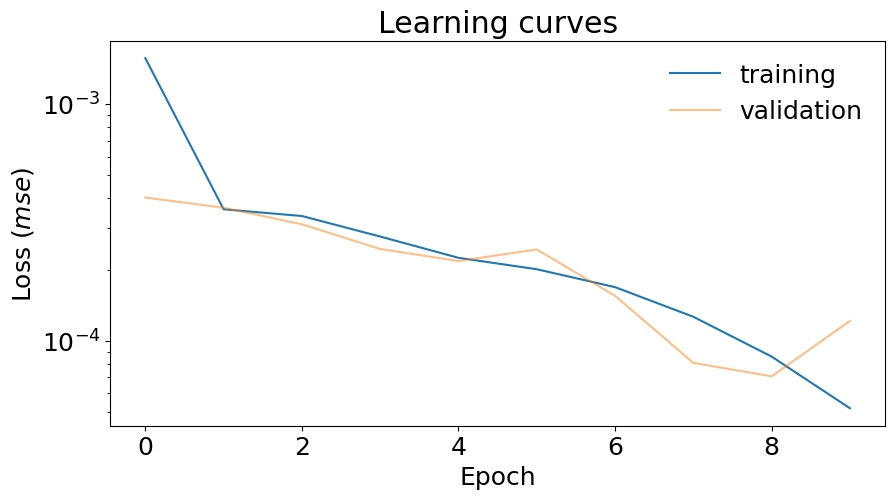

In [7]:
modelpath = savefilename+'_restart.tar'
checkpoint = torch.load(modelpath)
epoch = checkpoint['epoch']
loss_history = np.load(savefilename+'_epoch'+str(epoch+1)+'_losshistory.npy')

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})
plt.title('Learning curves')
plt.plot(loss_history[:,0], label='training')
plt.plot(loss_history[:,1], label='validation',alpha=0.5)
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel(r'Loss ($mse$)')
plt.legend(frameon=False);

## Evaluate the model & prediction

* Make a separate dataloader for test dataset

In [8]:
n_testsamples = test_data.shape[0]
temp_MLop = model( torch.from_numpy( np.array(test_data) ) )
test_OP_ML = temp_MLop.detach().numpy()
mse = mean_squared_error(test_OP,test_OP_ML, multioutput='uniform_average')
msefull = mean_squared_error(test_OP,test_OP_ML, multioutput='raw_values')
print('Test MSE: %4.3e (RMSE: %4.3e)' % (mse, math.sqrt(mse)))
print(f'R2 values = {np.round([metrics.r2_score(test_OP[:,i], test_OP_ML[:,i]) for i in range(4)], 2)}')

Test MSE: 1.206e-04 (RMSE: 1.098e-02)
R2 values = [0.47 0.33 0.75 0.74]


## Plotting the results

### Plot predicted output 
* (in scaled form if applicable)

In [9]:
data_op_varnames = ['Horizontal kinetic energy, $E_H$', 'Vertical kinetic energy, $E_V$', 'Potential energy, $E_P$', 'Buoyancy flux, $bw$']

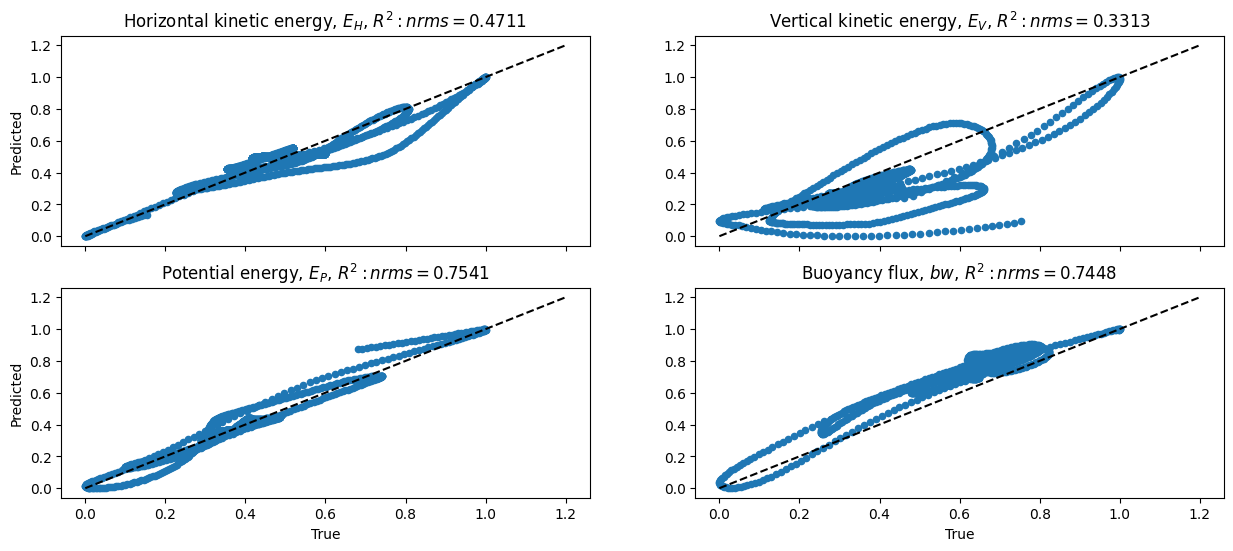

In [10]:
def min_max_norm(y):
    ymin = np.min(y)
    ymax = np.max(y)
    return (y - ymin) / (ymax - ymin)
plt.rcParams.update({'font.size': 10})
# plt.style.use('classic'), plt.style.use('style_mgm')
fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(min_max_norm(test_OP[:,i]), min_max_norm(test_OP_ML[:,i]), s=20)
    axs[i].plot(np.linspace(0,1.2),np.linspace(0,1.2),'--',color='k')
    r2 = metrics.r2_score(test_OP[:,i], test_OP_ML[:,i])
    axs[i].set_title(r''+data_op_varnames[i]+', $R^2: nrms = %0.4f$' % (r2))
axs[2].set_xlabel(r'True'); axs[3].set_xlabel(r'True');
axs[0].set_ylabel(r'Predicted'); axs[2].set_ylabel(r'Predicted');

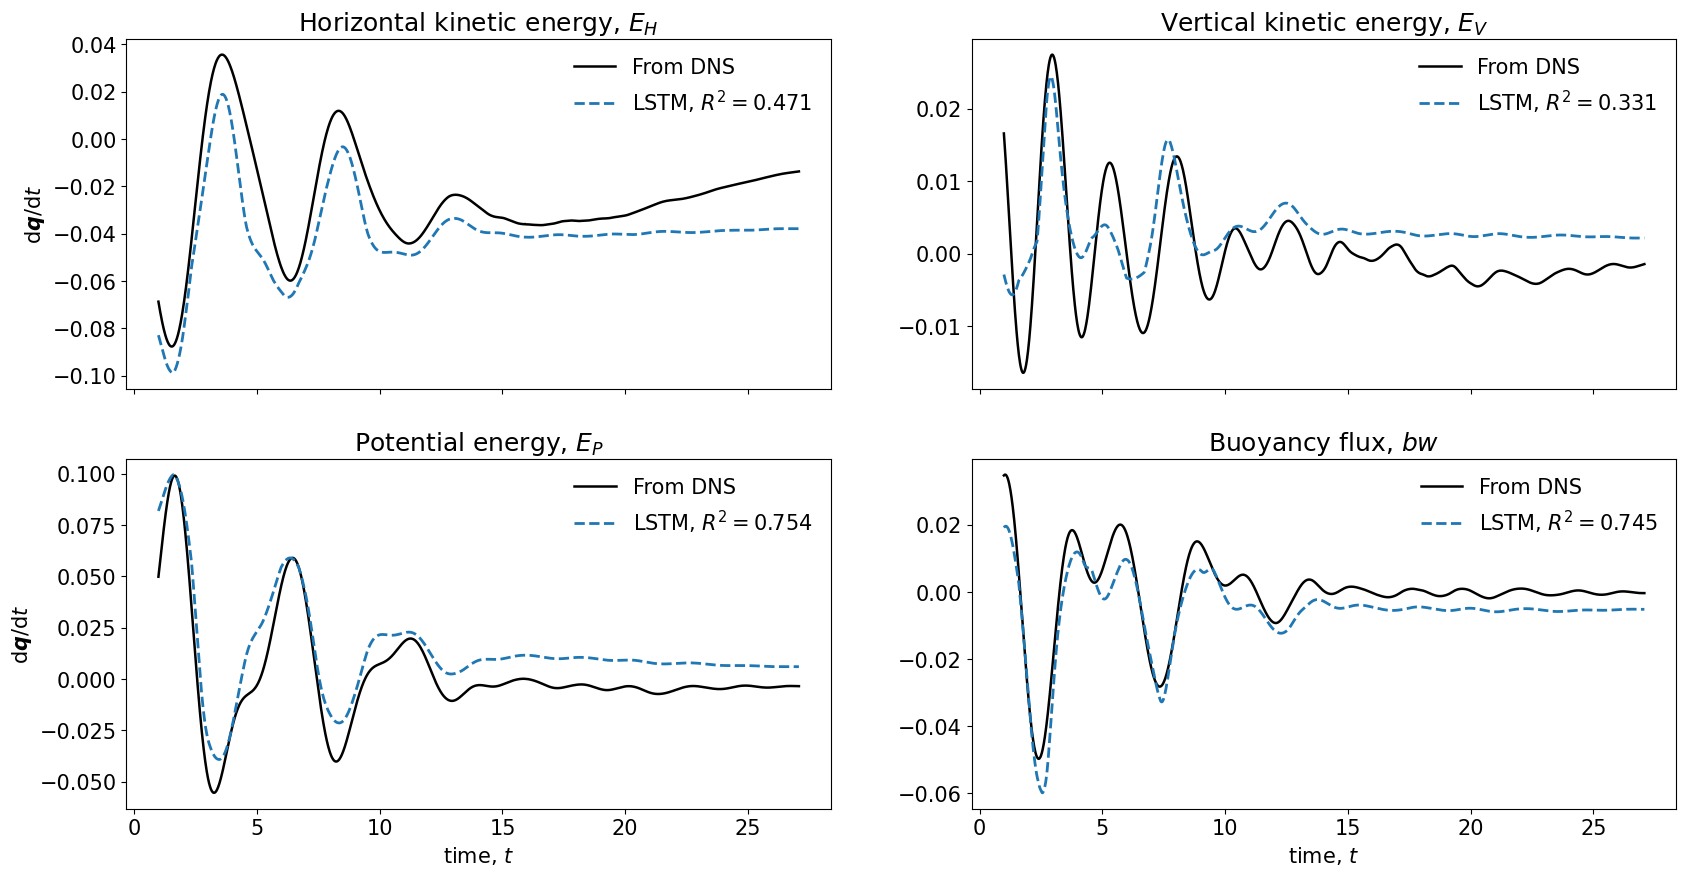

In [11]:
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(2,2,figsize=(20,10), sharex=True, facecolor="1")
axs = axs.ravel()
for i in range(n_outputs):
    axs[i].plot(test_time, test_OP[:,i],'k-', linewidth=1.8, label='From DNS')
    r2 = metrics.r2_score(test_OP[:,i], test_OP_ML[:,i])
    axs[i].plot(test_time, test_OP_ML[:,i], '--', color='tab:blue', linewidth=2, label=f'LSTM, $R^2 = {r2:0.3}$')
    
    axs[i].set_title(f'{data_op_varnames[i]}')
    axs[i].legend(frameon=False);
axs[0].set_ylabel(r'$\text{d} \boldsymbol{q}/ \text{d} t$');
axs[2].set_ylabel(r'$\text{d} \boldsymbol{q}/ \text{d} t$');
axs[2].set_xlabel(r'time, $t$'); 
axs[3].set_xlabel(r'time, $t$');

if saveFig: plt.savefig(f'{fnameFig}.pdf', format='pdf', bbox_inches='tight') #,dpi=100)

if saveData:
    np.savez(fnameData,
             test_time=test_time,test_OP=test_OP, test_OP_ML=test_OP_ML,
             data_op_varnames=data_op_varnames)